In this notebook, I try logistic regression, random forest, and boosted trees to build fraud detection models. The goal is to capture the most fraud records when looking at the top 3% of the dataset ranked by the output of the model. In other words, the objective is to choose the model with the highest average fraud detection rate at 3% as our finalized model.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import re
start_time = pd.datetime.now()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  if __name__ == '__main__':


In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import pickle

In [4]:
df = pd.read_csv('/content/drive/My Drive/5. USC/3. Spring 2020/DSO562 Fraud/Project/project03/card transactions_final.csv', index_col=0)

In [5]:
df

,Recnum,Date,Fraud,Cardnum_Merchnum_sum_7,Cardnum_Merchnum_max_3,Cardnum_Merchzip_max_3,Merchnum_sum_1,Cardnum_Merchzip_max_1,Cardnum_sum_1,Cardnum_Merchzip_max_0,Merchnum_max_1,Cardnum_max_0,Merchnum_max_3,Cardnum_max_14,Cardnum_sum_14,Cardnum_Merchzip_mean_0,Cardnum_mean_0,Cardnum_Merchzip_mean_30,Cardnum_Merchnum_mean_7,Cardnum_Merchnum_mean_1,Cardnum_Merchzip_mean_14,Cardnum_Merchnum_max_7,Cardnum_Merchzip_max_30,Cardnum_sum_0,Cardnum_Merchstate_sum_3,Cardnum_Merchnum_sum_0,Cardnum_Merchzip_sum_30,Cardnum_Merchzip_sum_7,Cardnum_Merchstate_sum_14,Cardnum_Merchzip_sum_1,Cardnum_Merchzip_sum_0
0,1,2010-01-01,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.620,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
1,2,2010-01-01,0,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.420,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42
2,3,2010-01-01,0,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.490,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49
3,4,2010-01-01,0,3.62,3.62,3.62,7.24,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.620,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
4,5,2010-01-01,0,7.24,3.62,3.62,10.86,3.62,7.24,3.62,3.62,3.62,3.62,3.62,7.24,3.62,3.620,3.62,3.62,3.62,3.62,3.62,3.62,7.24,7.24,7.24,7.24,7.24,7.24,7.24,7.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96392,96749,2010-12-31,0,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.790,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79,84.79
96393,96750,2010-12-31,0,118.75,118.75,118.75,118.75,118.75,803.75,118.75,118.75,685.00,118.75,1705.60,8089.20,118.75,401.875,359.30,118.75,118.75,359.30,118.75,599.85,803.75,886.25,118.75,718.60,118.75,2871.10,118.75,118.75
96394,96751,2010-12-31,0,363.56,363.56,363.56,5780.89,363.56,1501.14,363.56,2487.98,363.56,2487.98,1065.73,2578.13,363.56,363.560,363.56,363.56,363.56,363.56,363.56,363.56,363.56,435.41,363.56,363.56,363.56,435.41,363.56,363.56
96395,96752,2010-12-31,0,2202.03,2202.03,2202.03,5721.23,2202.03,2202.03,2202.03,2312.55,2202.03,2312.55,2202.03,3784.47,2202.03,2202.030,915.21,2202.03,2202.03,2202.03,2202.03,2202.03,2202.03,2202.03,2202.03,2745.63,2202.03,2202.03,2202.03,2202.03


In [6]:
# train-test split
X_train = df[(df.Date>'2010-01-14')&(df.Date<'2010-11-01')].iloc[:,3:].reset_index(drop=True)
X_test = df[(df.Date>='2010-11-01')].iloc[:,3:].reset_index(drop=True)
y_train = df[(df.Date>'2010-01-14')&(df.Date<'2010-11-01')]['Fraud'].reset_index(drop=True)
y_test = df[(df.Date>='2010-11-01')]['Fraud'].reset_index(drop=True)

In [7]:
# z-scale
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## Modeling

Here is the summary of the steps for modeling:
- Apply logistic regression, random forest, and boosted tree algorithms to build a fraud detection model
- For each algorithm, build several models with different parameters
- For each model, split the data into training/validation data
- Train each model with the training dataset and use it to predict the output of the training and validation dataset
- Then, rank the records in descending order of the probability score, and calculate the fraud detection rate at 3% of the population.
- Iterate the steps for each model 10 times and average the FDR at 3%. I am using the heuristic way of optimizing parameters instead of the general cross-validation method to minimize statistical fluctuation due to the lack of number of records
- Chose the model with the highest average FDR at 3% on the validation dataset as our final fraud detection model

In [8]:
def calculateFDR(predict, fraudscore, y, percent=0.03):
  temp = pd.DataFrame({'true':y.tolist(), 'predict':predict, 'score':fraudscore})
  temp.sort_values('score', ascending=False, inplace=True)
  count = int(temp.shape[0]*percent)
  return np.sum(temp.true[0:count])/np.sum(temp.true)

In [9]:
def modeling(X, y, model, iter):
    fdr_df=[]
    fdr_total=[0,0]
    for i in range(iter):
        X_train, X_val, y_train, y_val = train_test_split(X, y) # using default setting for test_size(0.25), random_state(None) and shuffle(True)
        model.fit(X_train, y_train)
        data = [[X_train, y_train], [X_val, y_val]]
        for d in range(len(data)):
            predict = model.predict(data[d][0])
            prob = model.predict_proba(data[d][0])
            fraudscore = prob.transpose()[1]
            fdr_each = calculateFDR(predict, fraudscore, data[d][1])
            fdr_total[d] += fdr_each
    
    avg_train = fdr_total[0] / iter
    avg_test = fdr_total[1] / iter
    result = [avg_train, avg_test]
    return result

### Logistic Regression

I start with the logistic regression as a baseline model. The important hyperparameter for logistic regression is C, the regularization term.

In [10]:
C = [0.01, 0.1, 1, 10]

max_train = 0
max_val = 0
for i in C:
  logit = LogisticRegression(C=10, max_iter=2000)
  temp = modeling(X_train, y_train, model=logit, iter=10)
  if max_val < temp[1] and temp[0] >= temp[1]:
      max_train=temp[0]
      max_val=temp[1]
      maxparams=dict(zip(['C'], [i]))
                
print(f'The best parameters are {maxparams} with fdr of {max_train} on training and {max_val} on validation data')

The best parameters are {'C': 1} with fdr of 0.7057074508716761 on training and 0.6874696030459587 on validation data


In [11]:
models_table = pd.DataFrame(index=['logit','rf','boosted'], columns=['model','parameters', 'train_fdr', 'val_fdr'])

In [12]:
models_table.loc['logit'] = ['logit', maxparams, max_train, max_val]

### Random Forest

A random forest is a supervised learning algorithm which is an ensemble of many strong decision trees. It de-correlates
the trees by taking bootstrapped samples and using a random sample of features when building each decision tree. The important hyperparameters in the random forest are the number of trees, the maximum
number of features in each tree, and the maximum depth of each tree.

In [13]:
n_estimators = [50, 100, 150]
max_features = ['sqrt', 'log2']
max_depth = [25, 50]

max_train = 0
max_val = 0
for i in n_estimators:
  for j in max_features:
    for k in max_depth:
      rf = RandomForestClassifier(n_estimators=i, max_features=j, max_depth=k)
      temp = modeling(X_train, y_train, model=rf, iter=10)
      if max_val < temp[1] and temp[0] >= temp[1]:
          max_train=temp[0]
          max_val=temp[1]
          maxparams=dict(zip(['n_estimators','max_features','max_depth'], [i,j,k]))
                
print(f'The best parameters are {maxparams} with fdr of {max_train} on training and {max_val} on validation data')

The best parameters are {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 25} with fdr of 1.0 on training and 0.9026605799864207 on validation data


In [14]:
models_table.loc['rf'] = ['rf', maxparams, max_train, max_val]

### Boosted Trees

boosted trees is a supervised learning algorithm composed of a series of weak learners to result in a strong learner. Each weak learners are typically shallow decision trees and we predict the dependent variable based on the sum of the scores from all the weak learners. The important hyperparameters in the boosted tree are the depth of the trees, the number of trees and the learning rate.

In [15]:
learning_rate = [0.1, 0.01]
n_estimators = [100, 200, 300]
max_depth = [1,3,5]

max_train = 0
max_val = 0
for i in learning_rate:
  for j in n_estimators:
    for k in max_depth:
      boosted = GradientBoostingClassifier(learning_rate=i, n_estimators=j, max_depth=k)
      temp = modeling(X_train, y_train, model=boosted, iter=10)
      if max_val < temp[1] and temp[0] >= temp[1]:
          max_train=temp[0]
          max_val=temp[1]
          maxparams=dict(zip(['learning_rate','n_estimators','max_depth'], [i,j,k]))
                
print(f'The best parameters are {maxparams} with fdr of {max_train} on training and {max_val} on validation data')

The best parameters are {'learning_rate': 0.1, 'n_estimators': 300, 'max_depth': 5} with fdr of 1.0 on training and 0.8963231730943931 on validation data


In [16]:
models_table.loc['boosted'] = ['boosted', maxparams, max_train, max_val]

In [17]:
models_table

,model,parameters,train_fdr,val_fdr
logit,logit,{'C': 1},0.705707,0.68747
rf,rf,"{'n_estimators': 100, 'max_features': 'sqrt', ...",1,0.902661
boosted,boosted,"{'learning_rate': 0.1, 'n_estimators': 300, 'm...",1,0.896323


### Final model

Now, I re-train the model with the entire training data and check the performance on the test data.

In [24]:
params_final = models_table.loc['rf', 'parameters']
params_final

{'max_depth': 25, 'max_features': 'sqrt', 'n_estimators': 100}

In [28]:
model = RandomForestClassifier(n_estimators=params_final['n_estimators'], max_features=params_final['max_features'], max_depth=params_final['max_depth'])
model.fit(X_train, y_train)
data = [[X_train, y_train], [X_test, y_test]]
fdr_final=[0,0]

for d in range(len(data)):
  predict = model.predict(data[d][0])
  prob = model.predict_proba(data[d][0])
  fraudscore = prob.transpose()[1]
  fdr_each = calculateFDR(predict, fraudscore, data[d][1])
  fdr_final[d] = fdr_each

print(f'The final model with random forest has FDR of {fdr_final[0]} on training and {fdr_final[1]} on validation data')

The final model with random forest has FDR of 1.0 on training and 0.553072625698324 on validation data


In [34]:
pickle.dump(model, open('/content/drive/My Drive/Colab Notebooks/fraud3_final_model','wb'))

## Conclusion

In the conclusion, I introduce and analyze a hypothetical setting on the test data to suggest the client a score cutoff of 8% that maximizes the overall fraud savings from labeling all transactions below that threshold as fraudulent.

Assumptions:
- Saving per correct fraud caught: \$2000
- Opportunity/transaction loss from a record identified as a false positive: \$50

In [133]:
savings = pd.DataFrame(y_test)
savings['score'] = fraudscore
savings['predict'] = predict
savings.sort_values('score', ascending=False, inplace=True)

In [134]:
savings['savings'] = 2000*savings.Fraud.cumsum()
savings['lost_sales'] = (np.ones(len(savings))*50).cumsum()
savings['net_savings'] = savings['savings'] - savings['lost_sales']
savings['bins'] = (np.ones(len(savings))/len(savings)*100).cumsum()

In [135]:
savings

,Fraud,score,predict,savings,lost_sales,net_savings,bins
5151,1,0.96,1,2000,50.0,1950.0,0.008047
5121,1,0.96,1,4000,100.0,3900.0,0.016094
5142,1,0.96,1,6000,150.0,5850.0,0.024141
5144,1,0.96,1,8000,200.0,7800.0,0.032188
5104,1,0.96,1,10000,250.0,9750.0,0.040235
...,...,...,...,...,...,...,...
2488,0,0.00,0,358000,621150.0,-263150.0,99.967812
2493,0,0.00,0,358000,621200.0,-263200.0,99.975859
11023,0,0.00,0,358000,621250.0,-263250.0,99.983906
5546,0,0.00,0,358000,621300.0,-263300.0,99.991953


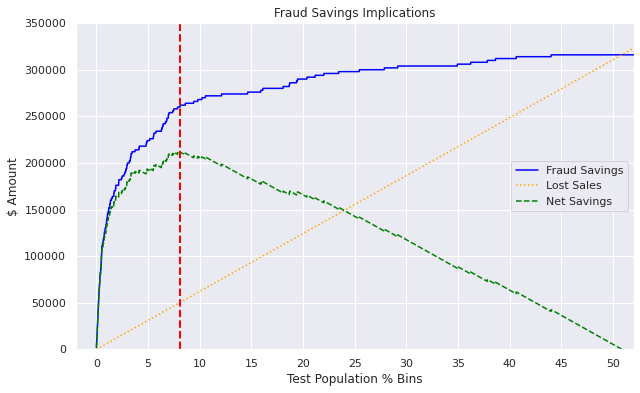

In [169]:
sns.set()
plt.figure(figsize=(10, 6))
plt.plot('bins', 'savings', data=savings, color='blue', label='Fraud Savings')
plt.plot('bins', 'lost_sales', data=savings, color='orange', linestyle=':', label='Lost Sales')
plt.plot('bins', 'net_savings', data=savings, color='green', linestyle='--', label='Net Savings')
plt.xlim(-2, 52)
plt.xticks(np.arange(0,51,5))
plt.ylim(0, 350000)
plt.axvline(x=savings.loc[savings.net_savings.idxmax(), 'bins'], linestyle='--', linewidth=2, color='red') 
plt.xlabel('Test Population % Bins')
plt.ylabel('$ Amount')
plt.title('Fraud Savings Implications')
plt.legend()
plt.show()

In [155]:
print('The best cut-off point is at {}% with the net savings of {} dollars'.format(round(savings.loc[savings.net_savings.idxmax(), 'bins']), savings.loc[savings.net_savings.idxmax(), 'net_savings']))

The best cut-off point is at 8.0% with the net savings of 211650.0 dollars


In [18]:
end_time = pd.datetime.now()
print(end_time - start_time)

6:34:49.258466


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.
